In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import SimpleITK as sitk
from util import read_sitk, plot_ct, xyz2irc
import os 
from tqdm import  tqdm

In [20]:
SPACING = [1.0, 1.0, 1.0]   # resampling 1mmx1mmx1mm

### Create Extend box (drop background)

In [21]:
def create_extendbox(img_mask, old_spacing, new_spacing=SPACING):
    m1 = img_mask == 3
    m2 = img_mask == 4

    Mask = m1 + m2
    xx, yy, zz = np.where(Mask)

    newshape = np.round(np.array(Mask.shape)*old_spacing/new_spacing).astype('int') 
    box = np.array([[np.min(xx),np.max(xx)],[np.min(yy),np.max(yy)],[np.min(zz),np.max(zz)]])
    # print(np.array(old_spacing)/np.array(new_spacing))
    # print(box)
    box = box * (np.array(old_spacing)/np.array(new_spacing)).reshape((-1, 1))
    # box = box*np.array(old_spacing)/np.array(new_spacing)
    box = np.floor(box).astype('int')
    margin = 5
    extendbox = np.vstack([np.max([[0,0,0],box[:,0]-margin],0),np.min([newshape,box[:,1]+margin],axis=0).T]).T

    return extendbox


### Resampling

In [22]:
from scipy import ndimage

In [23]:
def rescale_spacing(image, old_spacing, new_spacing):
    # Tính toán tỷ lệ thay đổi spacing
    scale_factor = np.array(old_spacing) / np.array(new_spacing)

    # Tính toán kích thước mới của ảnh CT
    new_shape = np.round(image.shape * scale_factor)
    new_shape = new_shape.astype(int)

    # Thay đổi kích thước ảnh CT bằng phương pháp nội suy
    resized_image = ndimage.zoom(image, scale_factor, mode='nearest')

    return resized_image


# main function
def resampling(img, old_spacing, new_spacing=SPACING):

    resized_img = rescale_spacing(img, old_spacing, new_spacing)

    return resized_img

### Mask nodule

In [59]:
def to_mask(img, label):
    tensor = np.zeros((img.shape[0], img.shape[1]))

    center_x, center_y = label[0], label[1]
    x_coords, y_coords = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    distance = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    diameters = label[2]
    tensor[distance <= diameters/2] = 1

    return tensor

def create_mask(img, circle_map):
    # check empty label
    if not circle_map:
        return np.zeros(img.shape), True
    #---    
    gt_mask = np.zeros(img.shape)
    # print(f"Statistic: min:{torch.min(img.float())} max:{torch.max(img.float())} mean:{torch.mean(img.float())}")
    for slice_idx, circle_list in circle_map.items():
        new_slice = to_mask(img[slice_idx], circle_list)
        gt_mask[slice_idx] = new_slice

    return gt_mask, False

def getPositiveMaskIndex(pos_mask):
    pos_slice_index = []
    for slice in range(pos_mask.shape[0]):
        if 1 in pos_mask[slice]:
            pos_slice_index.append(slice)
    return pos_slice_index

def buildAnnotationMask(hu_a, center_nodule_list, threshold_hu = -700, threshold_max=2000, is_center_reverse=False):

    boundingBox_a = np.zeros(hu_a.shape)
    for center_irc in center_nodule_list:
        ci = int(center_irc[0])
        cr = int(center_irc[1])
        cc = int(center_irc[2])    

        index_radius = 2
        try:
            while (hu_a[ci + index_radius, cr, cc] > threshold_hu and hu_a[ci + index_radius, cr, cc] < threshold_max) and \
                    hu_a[ci - index_radius, cr, cc] > threshold_hu and hu_a[ci - index_radius, cr, cc] < threshold_max:
                index_radius += 1
        except IndexError:
            index_radius -= 1

        row_radius = 2
        try:
            while hu_a[ci, cr + row_radius, cc] > threshold_hu and hu_a[ci, cr + row_radius, cc] < threshold_max and \
                    hu_a[ci, cr - row_radius, cc] > threshold_hu and hu_a[ci, cr - row_radius, cc] < threshold_max:
                row_radius += 1
        except IndexError:
            row_radius -= 1

        col_radius = 2
        try:
            while hu_a[ci, cr, cc + col_radius] > threshold_hu and hu_a[ci, cr, cc + col_radius] < threshold_max and \
                    hu_a[ci, cr, cc - col_radius] > threshold_hu and hu_a[ci, cr, cc - col_radius] < threshold_max:
                col_radius += 1
        except IndexError:
            col_radius -= 1

        boundingBox_a[
                 ci - index_radius: ci + index_radius + 1,
                 cr - row_radius: cr + row_radius + 1,
                 cc - col_radius: cc + col_radius + 1] = True

    boundingBox_a = np.array(boundingBox_a, dtype=bool)
    mask_a = boundingBox_a & (hu_a > threshold_hu) #& (hu_a < threshold_max)
    return mask_a

def make_mask(img_clean, label):
    circle_map_axial = {}
    for z_cen in label:
        cen = int(z_cen[0])
        circle_map_axial[cen] = z_cen[1:4]

    gt_mask, is_empty = create_mask(img_clean, circle_map_axial)
    heuristic_mask = np.zeros_like(gt_mask)
    if not is_empty:
        heuristic_mask = buildAnnotationMask(img_clean, label)

    gt_mask = np.array(gt_mask, dtype=bool)
    # Merge 2 mask
    result = heuristic_mask | gt_mask

    # get index
    pos_index = getPositiveMaskIndex(result)

    return result, pos_index

### Normalize

In [62]:
def normalize(img):
    # clip image
    new_img = np.copy(img)
    new_img = np.clip(new_img, -1100, 200)

    # normalization min-max normalization
    minn = new_img.min()
    maxx = new_img.max()
    # max_min = maxx - minn

    return (new_img - minn) / (maxx - minn)

### Pipeline processing

In [73]:
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def pipe_line(subset, save_path="../../luna16/full_processing"):
    luna_paths = glob.glob(f"../../luna16/LUNA16/subset{subset}/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd")
    annotation = pd.read_csv("../../luna16/annotations.csv")

    for path in tqdm(luna_paths):
        # check folder exists
        if not os.path.exists(save_path + f"/subset{subset}"):
            os.makedirs(save_path + f"/subset{subset}")
        if not os.path.exists(save_path + f"/subset{subset}-gt"):
            os.makedirs(save_path + f"/subset{subset}-gt")        

        # uid = path.split("\\")[-1][:-4]
        uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886"
        mask_path = glob.glob(f"../../luna16/seg-lungs-LUNA16/{uid}.mhd")[0]
        img_mask, _, _, _ = read_sitk(mask_path)

        img, origin,  spacing, direction = read_sitk(path)

        # check and flip 
        simple_direction = np.array((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
        direction = np.round(np.array(direction))
        if not np.array_equal(simple_direction, direction):
            img_mask = img_mask[:, ::-1, ::-1]
            img = img[:, ::-1, ::-1]

        # create extendbox
        extendbox = create_extendbox(img_mask, spacing)
        
        # caculation center mask in extendbox 
        this_annos = annotation[annotation['seriesuid'] == uid].drop(columns='seriesuid').to_numpy()
        label = []
        if len(this_annos) > 0:
            for c in this_annos:
                pos = worldToVoxelCoord(c[:3][::-1],origin=origin,spacing=spacing)
                if not np.array_equal(simple_direction, direction):
                    pos[1:] = img_mask.shape[1:3]-pos[1:]
                label.append(np.concatenate([pos,[c[3]/spacing[1]]]))
        
        if len(label) == 0:
            label1 = np.array([0, 0, 0, 0])
        else:
            label1 = np.copy(label).T
            label1[:3] = label1[:3]*((spacing/SPACING).reshape((-1, 1)))
            label1[3] = label1[3]*spacing[1]/SPACING[1]
            label1[:3] = label1[:3] - np.expand_dims(extendbox[:,0],1)
            label1 = label1.T
        
        # break

        ## full preprocessing
        # img_normalize = normalize(img)
        
        d1 = img_mask == 3
        d2 = img_mask == 4
        img_mask_pulmonary = d1 + d2
        img_pulmonary = img * img_mask_pulmonary

        # resampling
        img_resampling = resampling(img_pulmonary, spacing)

        # extendbox
        img_clean = img_resampling[extendbox[0,0]:extendbox[0,1],
                                    extendbox[1,0]:extendbox[1,1],
                                    extendbox[2,0]:extendbox[2,1]]

        # create mask
        mask, pos = make_mask(img_clean, label1)

        img_normalize = normalize(img_clean)

        # print(img_clean.shape)
        # print(extendbox)
        # print(origin)
        # print(label1)

        # save
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_clean.npy"), img_clean)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_extendbox.npy"), extendbox)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_origin.npy"), origin)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_label.npy"), label1)

        # save mask
        np.save(os.path.join(save_path, f"subset{subset}-gt/{uid}_gt.npy"), mask)
        np.save(os.path.join(save_path, f"subset{subset}-gt/{uid}_posindex.npy"), pos)

    
   
pipe_line(1)

100%|██████████| 1/1 [00:29<00:00, 29.84s/it]


### Test

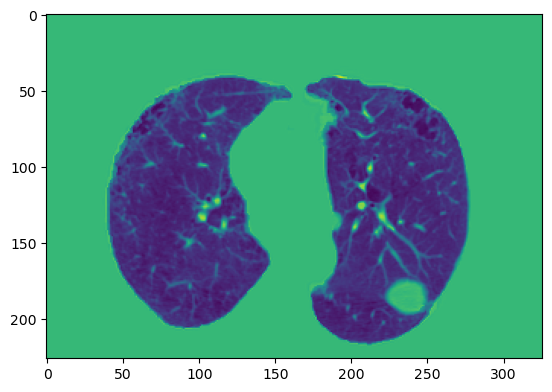

In [74]:
test_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886"
# luna_path = 
paths = glob.glob(f"../../luna16/full_processing/subset1/{test_uid}*")
index = np.load(glob.glob(f"../../preprocess/subset1-gt/{test_uid}_posindex.npy")[0])

img = np.load(paths[0])

plt.imshow(img[175])
plt.show()


[ 43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61 125 126 127 128 129 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199]


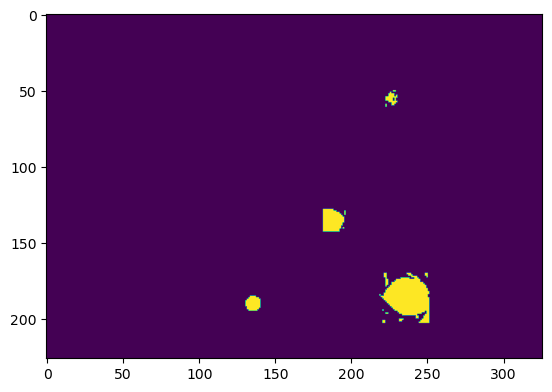

In [75]:
# mask
paths = glob.glob(f"../../luna16/full_processing/subset1-gt/{test_uid}_gt.npy")[0]
index = np.load(glob.glob(f"../../luna16/full_processing/subset1-gt/{test_uid}_posindex.npy")[0])
img = np.load(paths)

print(index)

plt.imshow(img[175])
plt.show()